True

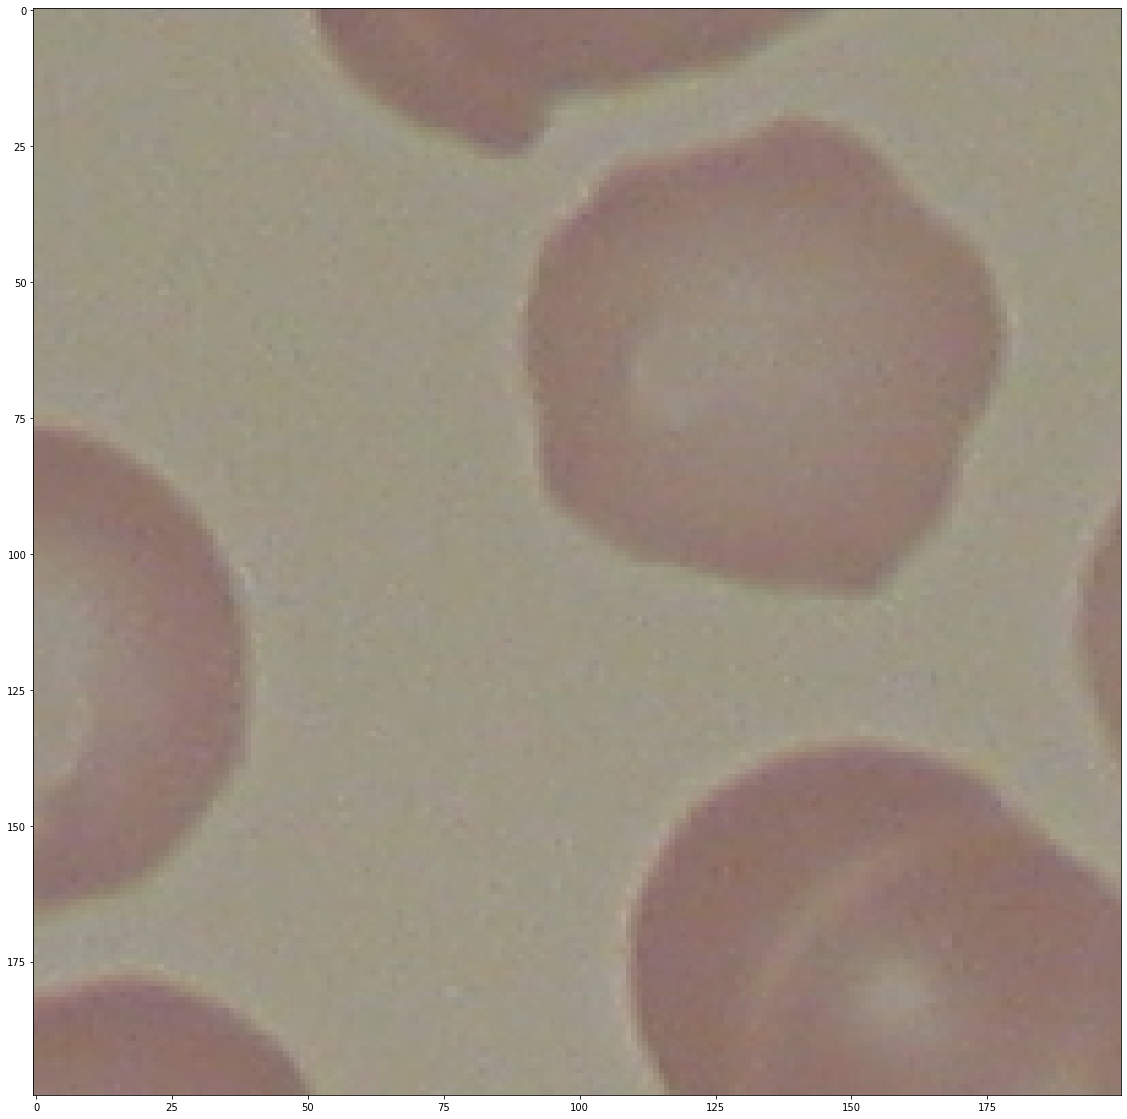

In [46]:
# source : https://jrtechs.net/photography/segmenting-images-with-quadtrees
# Open cv library
import cv2

# matplotlib for displaying the images 
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import random
import math
import numpy as np

img = cv2.imread('Im108_0.jpg')

left = 800
top = 250

size = 200

img = img[top: top + size, left:left + size]

def printI(img):
    fig= plt.figure(figsize=(20, 20))
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    
    
def printI2(i1, i2):
    fig= plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(cv2.cvtColor(i1, cv2.COLOR_BGR2RGB))
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(cv2.cvtColor(i2, cv2.COLOR_BGR2RGB))
    
printI(img)

cv2.imwrite(r"corped.jpg", img)
    

- a node represents a region in the image contains the coords of the top left pixel and the width, height + 4 child Nodes

- we have a loss function get_error which in this example favorise the green color

In [18]:
class Node():
    def __init__(self, x0, y0, w, h):
        self.x0 = x0
        self.y0 = y0
        self.width = w
        self.height = h
        self.children = []

    def get_width(self):
        return self.width
    
    def get_height(self):
        return self.height
    
    def get_points(self):
        return self.points
    
    def get_points(self, img):
        return img[self.x0:self.x0 + self.get_width(), self.y0:self.y0+self.get_height()]
    
    def get_error(self, img):
        pixels = self.get_points(img)
        b_avg = np.mean(pixels[:,:,0])
        b_mse = np.square(np.subtract(pixels[:,:,0], b_avg)).mean()
    
        g_avg = np.mean(pixels[:,:,1])
        g_mse = np.square(np.subtract(pixels[:,:,1], g_avg)).mean()
        
        r_avg = np.mean(pixels[:,:,2])
        r_mse = np.square(np.subtract(pixels[:,:,2], r_avg)).mean()
        
        e = r_mse * 0.5870 + g_mse * 0.2989 + b_mse * 0.1140
        
        return (e * img.shape[0]* img.shape[1])/90000000

In [19]:
class QTree():
    def __init__(self, stdThreshold, minPixelSize, img):
        self.threshold = stdThreshold
        self.min_size = minPixelSize
        self.minPixelSize = minPixelSize
        self.img = img
        self.root = Node(0, 0, img.shape[0], img.shape[1])

    def get_points(self):
        return img[self.root.x0:self.root.x0 + self.root.get_width(), self.root.y0:self.root.y0+self.root.get_height()]
    
    def subdivide(self):
        recursive_subdivide(self.root, self.threshold, self.minPixelSize, self.img)
    
    def graph_tree(self):
        fig = plt.figure(figsize=(10, 10))
        plt.title("Quadtree")
        c = find_children(self.root)
        print("Number of segments: %d" %len(c))
        for n in c:
            plt.gcf().gca().add_patch(patches.Rectangle((n.y0, n.x0), n.height, n.width, fill=False))
        plt.gcf().gca().set_xlim(0,img.shape[1])
        plt.gcf().gca().set_ylim(img.shape[0], 0)
        plt.axis('equal')
        plt.show()
        return

    def render_img(self, thickness = 1, color = (0,0,255)):
        imgc = self.img.copy()
        c = find_children(self.root)
        for n in c:
            pixels = n.get_points(self.img)
            # grb
            gAvg = math.floor(np.mean(pixels[:,:,0]))
            rAvg = math.floor(np.mean(pixels[:,:,1]))
            bAvg = math.floor(np.mean(pixels[:,:,2]))

            imgc[n.x0:n.x0 + n.get_width(), n.y0:n.y0+n.get_height(), 0] = gAvg
            imgc[n.x0:n.x0 + n.get_width(), n.y0:n.y0+n.get_height(), 1] = rAvg
            imgc[n.x0:n.x0 + n.get_width(), n.y0:n.y0+n.get_height(), 2] = bAvg

        if thickness > 0:
            for n in c:
                # Draw a rectangle
                imgc = cv2.rectangle(imgc, (n.y0, n.x0), (n.y0+n.get_height(), n.x0+n.get_width()), color, thickness)
        return imgc

In [21]:
def recursive_subdivide(node, k, minPixelSize, img):

    if node.get_error(img)<=k:
        return
    w_1 = int(math.floor(node.width/2))
    w_2 = int(math.ceil(node.width/2))
    h_1 = int(math.floor(node.height/2))
    h_2 = int(math.ceil(node.height/2))


    if w_1 <= minPixelSize or h_1 <= minPixelSize:
        return
    x1 = Node(node.x0, node.y0, w_1, h_1) # top left
    recursive_subdivide(x1, k, minPixelSize, img)

    x2 = Node(node.x0, node.y0+h_1, w_1, h_2) # btm left
    recursive_subdivide(x2, k, minPixelSize, img)

    x3 = Node(node.x0 + w_1, node.y0, w_2, h_1)# top right
    recursive_subdivide(x3, k, minPixelSize, img)

    x4 = Node(node.x0+w_1, node.y0+h_1, w_2, h_2) # btm right
    recursive_subdivide(x4, k, minPixelSize, img)

    node.children = [x1, x2, x3, x4]
   

def find_children(node):
   if not node.children:
       return [node]
   else:
       children = []
       for child in node.children:
           children += (find_children(child))
   return children

Number of segments: 1


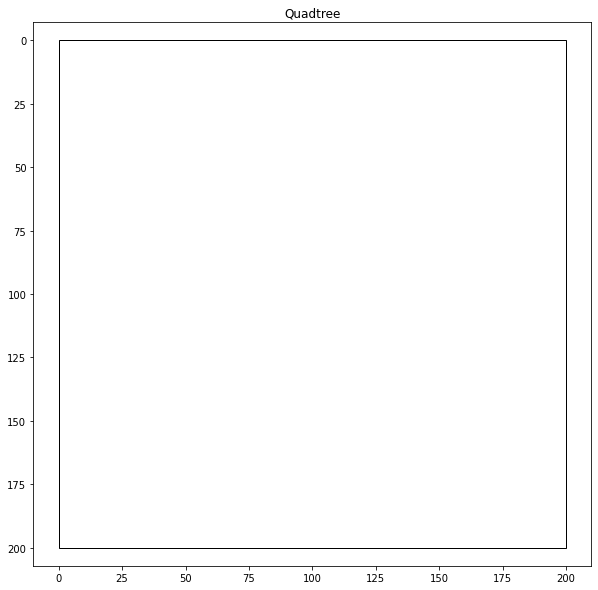

Number of segments: 1


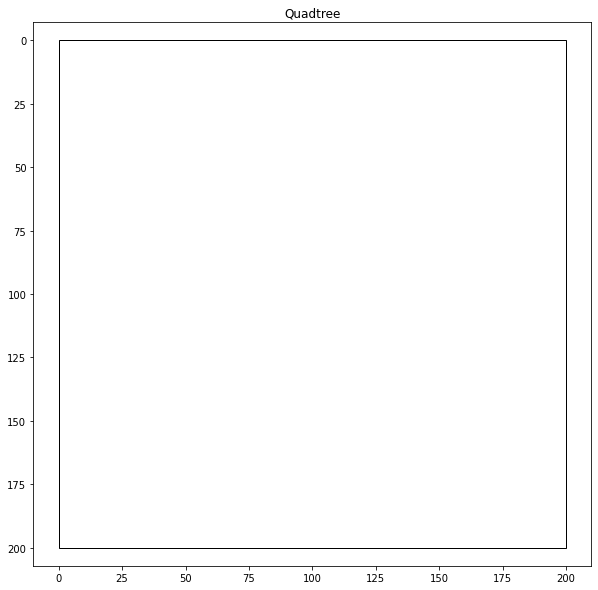

In [32]:
qtTemp = QTree(3, 3, img)  #contrast threshold, min cell size, img
qtTemp.subdivide() # recursively generates quad tree
qtTemp.graph_tree()

qtTemp2 = QTree(9, 5, img) 
qtTemp2.subdivide()
qtTemp2.graph_tree()

In [33]:
def concat_images(img1, img2, boarder=5, color=(255,255,255)):
    img1_boarder = cv2.copyMakeBorder(
                 img1, 
                 boarder, #top
                 boarder, #btn
                 boarder, #left
                 boarder, #right
                 cv2.BORDER_CONSTANT, 
                 value=color
              )
    img2_boarder = cv2.copyMakeBorder(
                 img2, 
                 boarder, #top
                 boarder, #btn
                 0, #left
                 boarder, #right
                 cv2.BORDER_CONSTANT, 
                 value=color
              )
    return np.concatenate((img1_boarder, img2_boarder), axis=1)

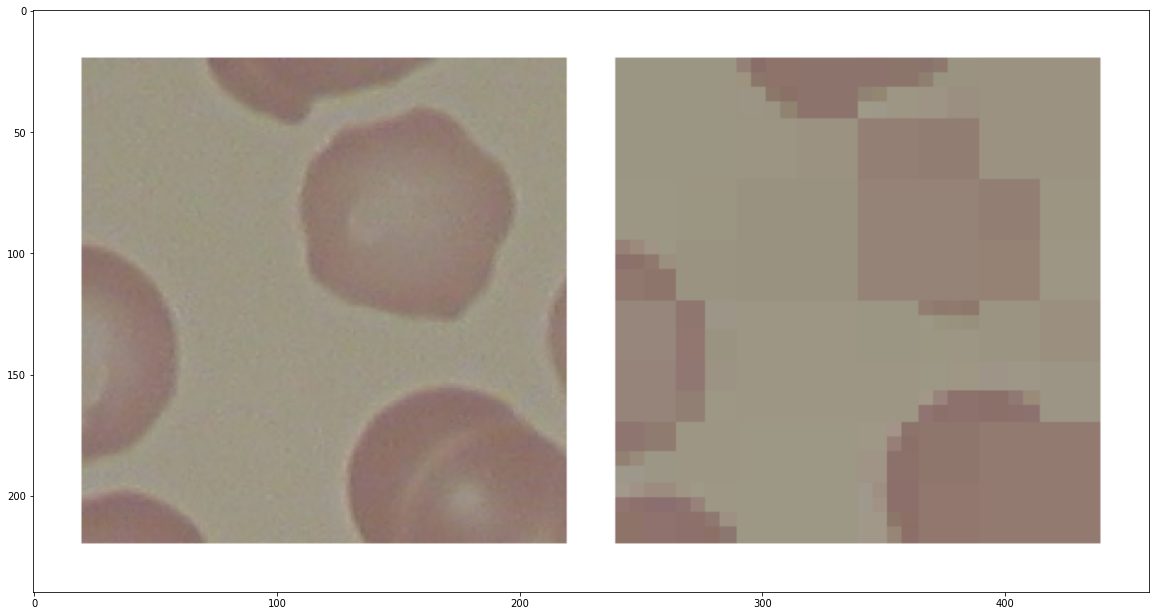

In [75]:
def displayQuadTree(img_name, threshold=7, minCell=3, img_boarder=20, line_boarder=1, line_color=(0,0,255)):
    imgT= cv2.imread(img_name)
    qt = QTree(threshold, minCell, imgT) 
    qt.subdivide()
    qtImg = qt.render_img(thickness=line_boarder, color=line_color)
    file_name = "output/" + img_name.split("/")[-1]
    cv2.imwrite(file_name,qtImg)
    file_name_2 = "output/diptych-" + img_name[-6] + img_name[-5] + ".jpg"
    hConcat = concat_images(imgT, qtImg, boarder=img_boarder, color=(255,255,255))
    cv2.imwrite(file_name_2,hConcat)
    printI(hConcat)

displayQuadTree("corped.jpg", threshold=0.037, img_boarder=20, line_color=(0,0,0), line_boarder = 0)

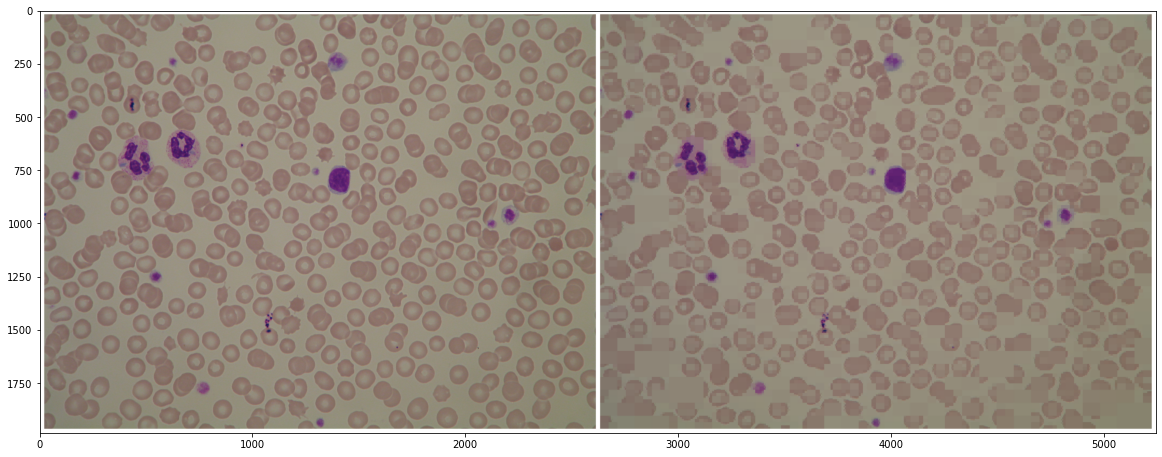

In [80]:
displayQuadTree("Im108_0.jpg", threshold=3.5, img_boarder=20, line_color=(0,0,0), line_boarder = 0)

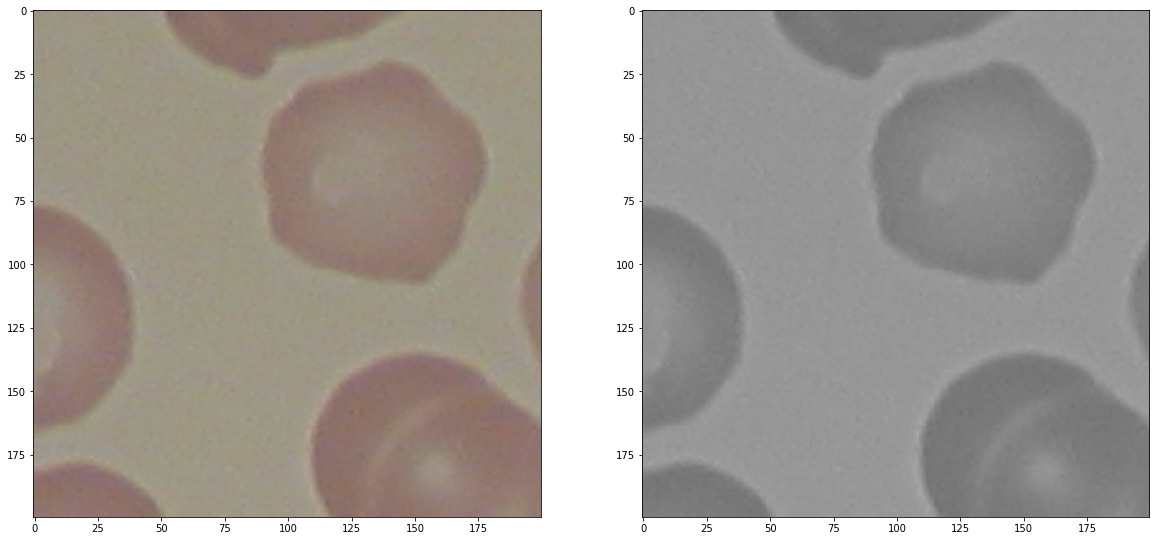

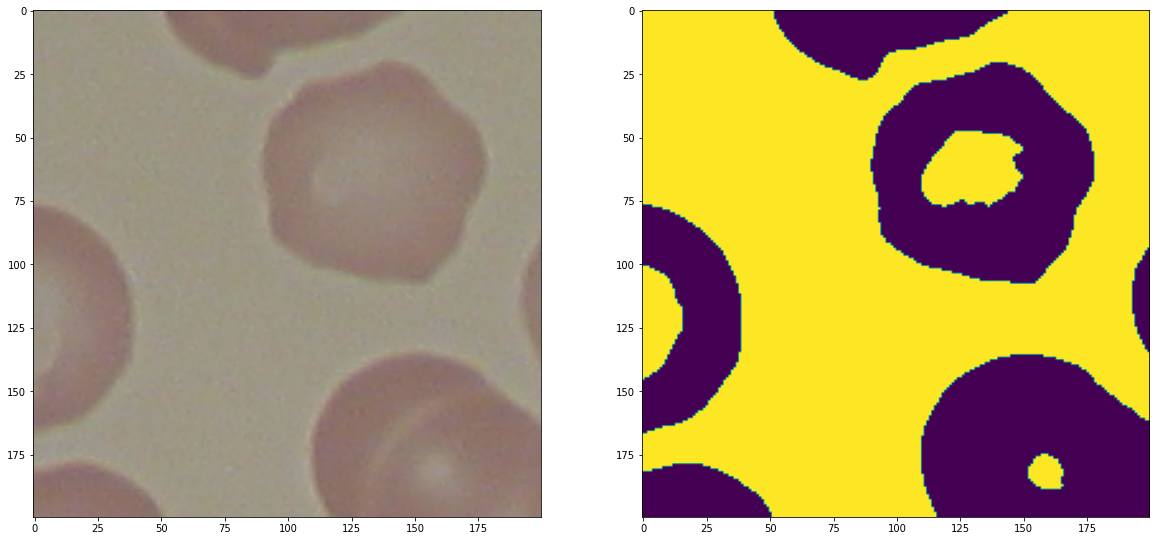

In [103]:
# convert the image to grayscale and blur it slightly
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

(T, threshInv) = cv2.threshold(blurred, 200, 255, 
                               cv2.THRESH_BINARY_INV)


(T, thresh) = cv2.threshold(blurred, 200, 255, 
                            cv2.THRESH_BINARY)

ret2,th2 = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


printI2(img, gray)
printI2(img, blurred)

plt.imshow(th2)